In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import ta

import optuna
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Statistical tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from prophet import Prophet

# Deep Models
from keras.models import Sequential
from keras.layers import Dense, LSTM

from transformers import pipeline
import warnings

# Model Analysis
from giskard import Model, Dataset, scan, testing, GiskardClient, demo, Suite

# Utility API
import utility

# Suppress all warnings
warnings.filterwarnings("ignore")
pd.set_option('display.width', 1000)


In [2]:
# Declare Global variables
company_name           = "AAPL"
ml_data_path           = "data/stocknet-dataset-master/price/raw/"
stats_data_path        = "data/price_us/"
filename               = ml_data_path + company_name + ".csv"

train_test_ratio       = 0.85
sliding_window         = 12
tweet_data_path        = 'data/stocknet-dataset-master/price/raw/' + company_name + ".csv"
tweet_dir_path         = 'data/stocknet-dataset-master/tweet/raw/' + company_name
tweet_text_pattern     = r'"text":"([^"]*)"'



######################################
##         Load the dataset         ##
######################################

!git clone -b master https://github.com/yumoxu/stocknet-dataset.git data/stocknet-dataset-master/
utility.load_yfstock_data()


######################################
##          Read the data           ##
######################################

data = pd.read_csv(filename)
train_test_split_idx = int(data.shape[0] * train_test_ratio)
print(data.head())

######################################
## Read data for statistical model  ##
######################################
stats_data = pd.read_csv(stats_data_path + company_name + ".csv")
stats_data_split_idx = int(stats_data.shape[0] * train_test_ratio)

######################################
##        Data for ARIMA model      ##
######################################
sm_data  = pd.DataFrame(stats_data['Close'])
sm_train = sm_data[:stats_data_split_idx]
sm_test  = sm_data[stats_data_split_idx:]



######################################
##       Data for Prophet model     ##
######################################
prophet_data = pd.DataFrame(stats_data[['Date', 'Close']])
# Convert date to datetime object
prophet_data['Date'] = pd.to_datetime(prophet_data['Date'], utc=True)
# Prophet expects data with two columns ds and y
prophet_data['ds'] = prophet_data['Date'].dt.date
prophet_data['y']  = prophet_data['Close']
prophet_train = prophet_data[:stats_data_split_idx]
prophet_test  = prophet_data[stats_data_split_idx:]



######################################
##    Data for Regression models    ##
######################################
reg_data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
reg_X = reg_data
reg_y = data['Close'].shift(-1)  # Shifting 'Close' to predict the next day's value
reg_X = reg_X[:-1] # Drop last entry as it will be NaN
reg_y = reg_y[:-1]
reg_X_train = reg_X[:train_test_split_idx]
reg_y_train = reg_y[:train_test_split_idx]
reg_X_test  = reg_X[train_test_split_idx:]
reg_y_test  = reg_y[train_test_split_idx:]
reg_plot_y_train = pd.DataFrame(data=reg_y_train, columns=['Close'])
reg_plot_y_test  = pd.DataFrame(data=reg_y_test, columns=['Close'])



##########################################################
##    Data for models using technical indicators        ##
##########################################################

df_technical_indicators = ta.add_all_ta_features(data, "Open", "High", "Low", "Close", "Volume", fillna=True)
ta_data = df_technical_indicators[['trend_sma_slow', 'volume_fi', 'volume_mfi', 'volatility_bbw', 'trend_macd', 'trend_mass_index', 'momentum_rsi']]
ta_X = ta_data
ta_y = data['Close'].shift(-1)  # Shifting 'Close' to predict the next day's value
ta_X = ta_X[:-1] # Drop last entry as it will be NaN
ta_y = ta_y[:-1]
ta_X_train = ta_X[:train_test_split_idx]
ta_y_train = ta_y[:train_test_split_idx]
ta_X_test  = ta_X[train_test_split_idx:]
ta_y_test  = ta_y[train_test_split_idx:]
ta_plot_y_train = pd.DataFrame(data=ta_y_train, columns=['Close'])
ta_plot_y_test  = pd.DataFrame(data=ta_y_test, columns=['Close'])

##########################################################
##        Preprocessing for Giskard Analysis            ##
##########################################################
reg_y_test_giskard = pd.DataFrame(reg_y_test)
reg_y_test_giskard.rename(columns = {'Close':'Target_Close'}, inplace = True)


fatal: destination path 'data/stocknet-dataset-master' already exists and is not an empty directory.


         Date       Open       High        Low      Close  Adj Close     Volume
0  2012-09-04  95.108574  96.448570  94.928574  96.424286  87.121140   91973000
1  2012-09-05  96.510002  96.621429  95.657143  95.747147  86.509338   84093800
2  2012-09-06  96.167145  96.898575  95.828575  96.610001  87.288956   97799100
3  2012-09-07  96.864288  97.497147  96.538574  97.205711  87.827171   82416600
4  2012-09-10  97.207146  97.612854  94.585716  94.677139  85.542564  121999500


# <b>Statistical models for Stock Price Prediction</b>

### <b>Auto ARIMA</b>

ARIMA has three components – 

* AR (autoregressive term) - Refers to past vallues used for forecasting. The value of ‘p’ is determined using the PACF plot.
* I (differencing term)    - Refers to order of differencing, i.e. number of times the differencing operation is performed on series to make it stationary.
* MA (moving average term) - Refers to number of past forecast errors used to predict the future values. ACF plot is used to identify the correct ‘q’ value.

Auto ARIMA automatically determines the optimal parameters for an ARIMA model.
It searches through different combinations of these parameters to find the best fit for the given time series data. 

Test RMSE:  22.22535424292554


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9193
Model:               SARIMAX(5, 2, 0)   Log Likelihood                4431.269
Date:                Sun, 19 Nov 2023   AIC                          -8850.538
Time:                        13:51:42   BIC                          -8807.782
Sample:                             0   HQIC                         -8836.004
                               - 9193                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8158      0.004   -225.033      0.000      -0.823      -0.809
ar.L2         -0.6732      0.004   -152.498      0.000      -0.682      -0.665
ar.L3         -0.5254      0.005   -102.999      0.000      -0.535      -0.515
ar.L4         -0.3425      0.005    -68.323      0.000      -0.352      -0.333
ar.L5         -0.1851      0.004    -45.921      0.000      -0.193      -0.177
sigma2         0.0223   8.65e-05    258.078      0.000       0.022       0.022
===================================================================================
Ljung-Box (L1) (Q):                   7.91   Jarque-Bera (JB):            356014.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            1303.26   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

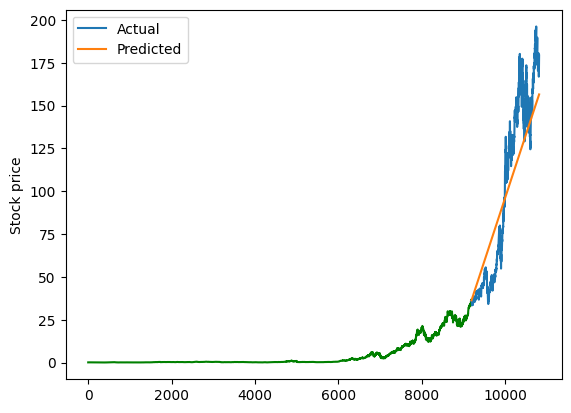

In [3]:
arima_model = auto_arima(sm_train, seasonal=True, stepwise=True, random_state=42)
arima_model.fit(sm_train)

# Predict the next n periods using Arima model
forecast = arima_model.predict(n_periods=sm_test.shape[0])

# Calculate RMSE and plot the predictions
mse = mean_squared_error(sm_test, forecast)
print('Test RMSE: ', np.sqrt(mse))

utility.plot_actual_predicted_val(sm_train, sm_test, forecast)

arima_model.summary()

### <b>Prophet</b>

Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components.

y(t) = g(t) + s(t) + h(t) + $\epsilon$(t)

g(t) - piecewise linear or logistic growth curve\
s(t) - seasonality component\
h(t) - effect of holidays - irregular schedules\
$\epsilon$(t) - error term accounts for irregularity not accounted for by model

Changepoints - \
There could be multiple factors that can affect the growth rate.\
For example, some very bad/good news about the company, excellent/poor financial results.
Prophet automatically identifies these, and allows for the growth rate to deviate at these points.

2023-11-19 13:51:42,420 pid:15206 MainThread prophet      INFO     Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-11-19 13:51:42,438 pid:15206 MainThread cmdstanpy    DEBUG    input tempfile: /var/folders/5g/c10l070n2x9b_38yc1pp8b7w0000gn/T/tmp_ddxlvty/24tsieyi.json
2023-11-19 13:51:42,712 pid:15206 MainThread cmdstanpy    DEBUG    input tempfile: /var/folders/5g/c10l070n2x9b_38yc1pp8b7w0000gn/T/tmp_ddxlvty/3x494g_n.json
2023-11-19 13:51:42,714 pid:15206 MainThread cmdstanpy    DEBUG    idx 0
2023-11-19 13:51:42,714 pid:15206 MainThread cmdstanpy    DEBUG    running CmdStan, num_threads: None
2023-11-19 13:51:42,714 pid:15206 MainThread cmdstanpy    DEBUG    CmdStan args: ['/Users/sbandlap/Mtech/mtech/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74604', 'data', 'file=/var/folders/5g/c10l070n2x9b_38yc1pp8b7w0000gn/T/tmp_ddxlvty/24tsieyi.json', 'init=/var/folders/5g/c10l070n2x9b_38yc1pp8b7w0000gn/T/tmp_dd

13:51:42 - cmdstanpy - INFO - Chain [1] start processing


2023-11-19 13:51:42,714 pid:15206 MainThread cmdstanpy    INFO     Chain [1] start processing


13:51:44 - cmdstanpy - INFO - Chain [1] done processing


2023-11-19 13:51:44,659 pid:15206 MainThread cmdstanpy    INFO     Chain [1] done processing


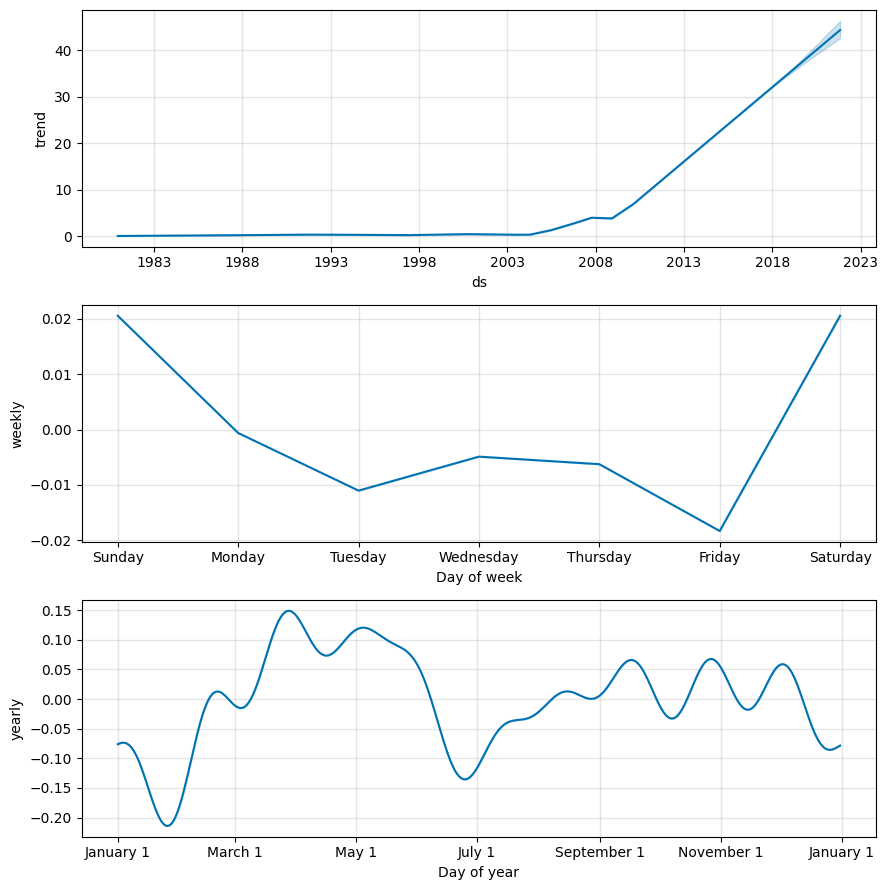

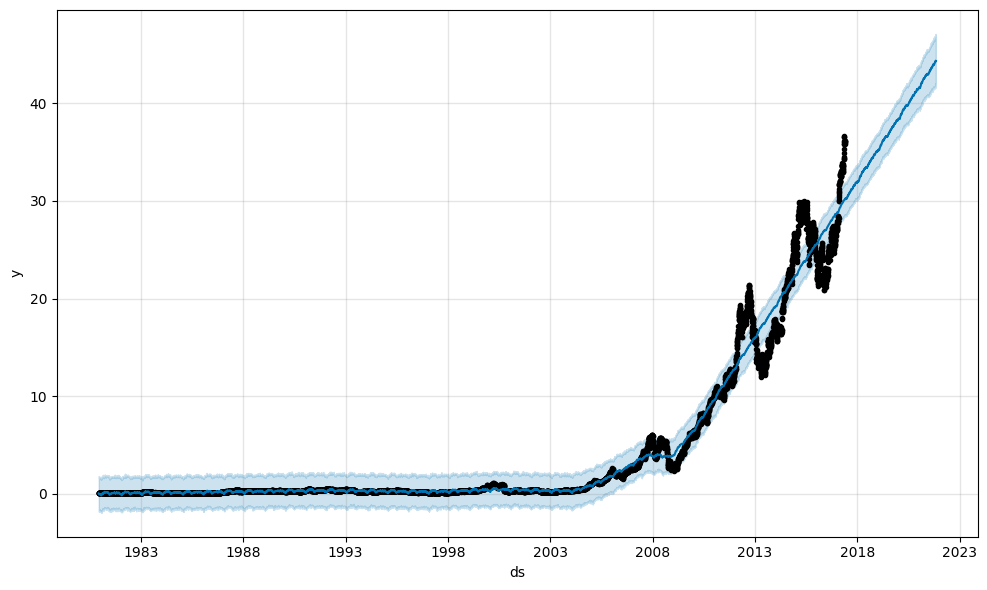

Test RMSE:  79.51104284610604


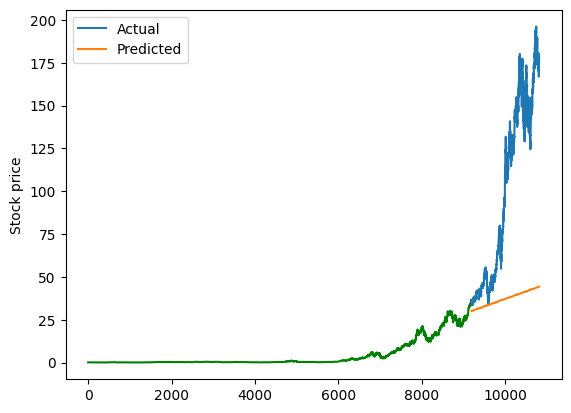

In [4]:
prophet_model = Prophet()
prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=prophet_test['y'].shape[0])
p_forecast = prophet_model.predict(future)

# Plot the trends in the data
prophet_model.plot_components(p_forecast);

# Plot the forecast
prophet_model.plot(p_forecast);
plt.show()

p_preds = p_forecast['yhat'][stats_data_split_idx:]

mse = mean_squared_error(prophet_test['y'], p_preds)
print('Test RMSE: ', np.sqrt(mse))

utility.plot_actual_predicted_val(prophet_train, prophet_test, p_preds)

# <b>Regression models for Stock price prediction</b>

Features: Yesterday's ['Open', 'High', 'Low', 'Close', 'Volume']<br>
Target: Today's [Close]

## <b>Linear Regression

Train RMSE:  1.5324429434158124
Test RMSE:  1.6123421246180047


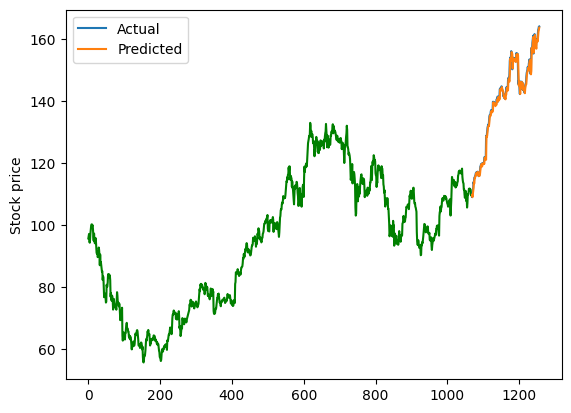

In [5]:
lr_model = LinearRegression()
lr_model.fit(reg_X_train, reg_y_train)

# Calculating Train RMSE
y_pred_lr = lr_model.predict(reg_X_train)
mse = mean_squared_error(reg_y_train, y_pred_lr)
print('Train RMSE: ', np.sqrt(mse))

# Calculate Test RMSE
y_pred_lr = lr_model.predict(reg_X_test)
mse = mean_squared_error(reg_y_test, y_pred_lr)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred_lr)

utility.get_giskard_analysis(reg_X_test, reg_y_test_giskard, 'Target_Close', lr_model, "Linear Regression based stock price prediction")

## <b>Decision Tree Regressor

Train RMSE:  1.4902710316503662
Test RMSE:  16.622544270850014


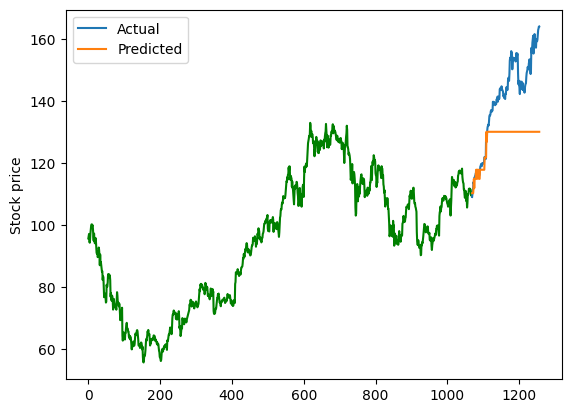

In [6]:
model = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [5, 8, 10, 12],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 2, 3, 4],
    'splitter': ['best'],
    'max_features': [5, 8, 10, 12, 'auto'] 
    }
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(reg_X_train, reg_y_train)
best_dt_regressor = grid_search.best_estimator_

# Calculating Train RMSE
y_pred = best_dt_regressor.predict(reg_X_train)
mse = mean_squared_error(reg_y_train, y_pred)
print('Train RMSE: ', np.sqrt(mse))

# Calculating Test RMSE
y_pred = best_dt_regressor.predict(reg_X_test)
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

utility.get_giskard_analysis(reg_X_test, reg_y_test_giskard, 'Target_Close', best_dt_regressor, "Decision Tree based stock price prediction")

## <b> ADBoost Regressor

Train RMSE:  0.3801707983533002
Test RMSE:  17.680257452266073


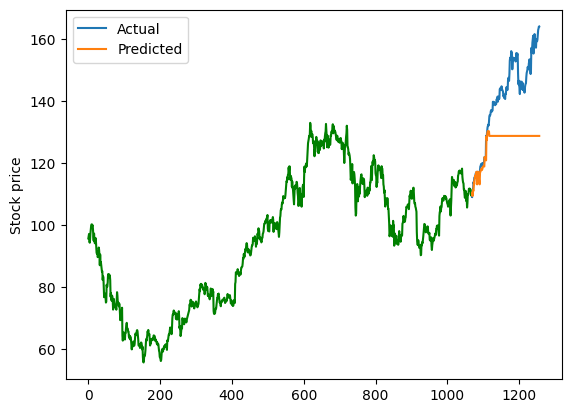

In [7]:
DTR       = DecisionTreeRegressor(max_depth=10)
ADBModel  = AdaBoostRegressor(n_estimators=100, base_estimator=DTR ,learning_rate=1e-3)

ADBModel.fit(reg_X_train,reg_y_train)

# Calculating Train RMSE
y_pred = ADBModel.predict(reg_X_train)
mse = mean_squared_error(reg_y_train, y_pred)
print('Train RMSE: ', np.sqrt(mse))

# Calculating Test RMSE
y_pred = ADBModel.predict(reg_X_test)
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

utility.get_giskard_analysis(reg_X_test, reg_y_test_giskard, 'Target_Close', ADBModel, "ADABoost model stock price prediction")

## <b> Random forest Regressor

Train RMSE:  1.377950221771283
Test RMSE:  16.888359896278526


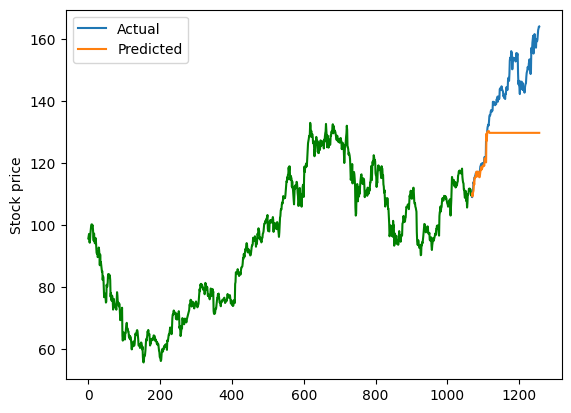

In [8]:
model = RandomForestRegressor()
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [5, 10, 15,20],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(reg_X_train, reg_y_train)
best_rf_regressor = grid_search.best_estimator_

# Calculating Train RMSE
y_pred = best_rf_regressor.predict(reg_X_train)
mse = mean_squared_error(reg_y_train, y_pred)
print('Train RMSE: ', np.sqrt(mse))

# Calculating Test RMSE
y_pred = best_rf_regressor.predict(reg_X_test)
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred) 

utility.get_giskard_analysis(reg_X_test, reg_y_test_giskard, 'Target_Close', best_rf_regressor, "Random Forest stock price prediction")

## <b>Support Vector Regressor

Train RMSE:  2.2735734492392576
Test RMSE:  33.969911344287276


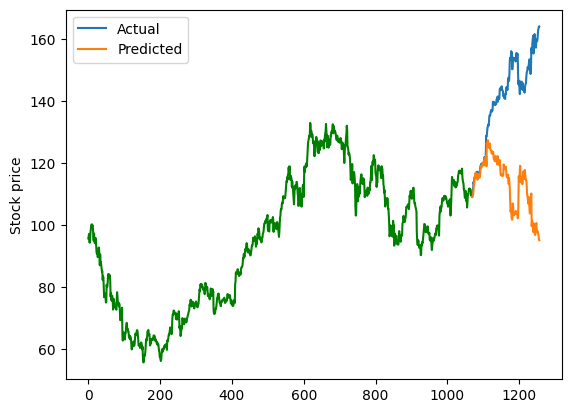

In [9]:
SVRModel = make_pipeline(StandardScaler(), SVR(kernel='linear'))
SVRModel.fit(reg_X_train,reg_y_train)

# Calculating Train RMSE
y_pred = SVRModel.predict(reg_X_train)
mse = mean_squared_error(reg_y_train, y_pred)
print('Train RMSE: ', np.sqrt(mse))

# Calculating Test RMSE
y_pred = SVRModel.predict(reg_X_test)
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

utility.get_giskard_analysis(reg_X_test, reg_y_test_giskard, 'Target_Close', SVRModel, "SVR stock price prediction")

## <b>XGBoostRegressor with Optuna</b>

[I 2023-11-19 14:15:17,177] A new study created in memory with name: no-name-37feaa26-c81c-4d1c-a5bb-77beb2ee242d
[I 2023-11-19 14:15:17,214] Trial 0 finished with value: 7.4374815527435025 and parameters: {'booster': 'gbtree', 'n_estimators': 163, 'subsample': 0.49880560984207234, 'colsample_bytree': 0.27983731642467813, 'min_child_weight': 2.782565782836616, 'lambda': 0.7605307121989587, 'alpha': 0.16911083656253545, 'max_depth': 1, 'eta': 0.003040034742832493, 'gamma': 0.4237861601304585, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.4374815527435025.
[I 2023-11-19 14:15:17,251] Trial 1 finished with value: 7.8280663118305425 and parameters: {'booster': 'gbtree', 'n_estimators': 94, 'subsample': 0.8342192980103548, 'colsample_bytree': 0.6716606267181524, 'min_child_weight': 5.882899312101351, 'lambda': 0.14217004760152696, 'alpha': 0.3733407600514692, 'max_depth': 7, 'eta': 3.4250380089316126e-05, 'gamma': 2.965595722907858e-05, 'grow_policy': 'depthwise'}. Best is tria

Train RMSE:  0.8915320765098548
Test RMSE:  3.8431980188302286


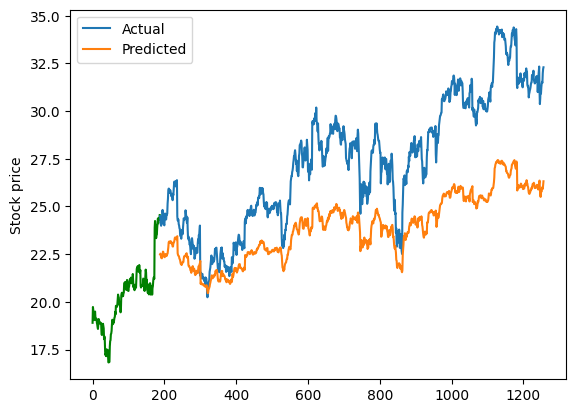

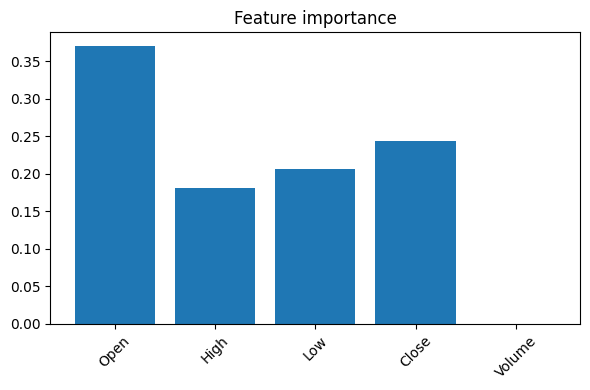

Test RMSE:  3.8431980188302286
Your model is successfully validated.
🔎 Running scan…
2023-11-19 14:15:26,814 pid:15206 MainThread giskard.scanner.logger INFO     Running detectors: ['DataLeakageDetector', 'EthicalBiasDetector', 'TextPerturbationDetector', 'PerformanceBiasDetector', 'StochasticityDetector']
Running detector DataLeakageDetector…
2023-11-19 14:15:26,815 pid:15206 MainThread giskard.scanner.logger INFO     DataLeakageDetector: Running
2023-11-19 14:15:26,830 pid:15206 MainThread giskard.scanner.logger ERROR    Detector DataLeakageDetector failed with error: zero-dimensional arrays cannot be concatenated
DataLeakageDetector: 0 issue detected. (Took 0:00:00.015895)
Running detector EthicalBiasDetector…
2023-11-19 14:15:26,831 pid:15206 MainThread giskard.scanner.logger INFO     EthicalBiasDetector: Running with transformations=['Switch Gender', 'Switch Religion', 'Switch countries from high- to low-income and vice versa'] threshold=None output_sensitivity=None num_samples=No

<iframe id="scan-13858545232" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co

In [25]:
# Create an objective for Optuna Study
def objective(trial):
    param = {
        "verbosity": 0,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.9),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1), 
        'objective': 'reg:squarederror',
        'random_state':42
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = xgb.XGBRegressor(**param)
    model.fit(reg_X_train, reg_y_train)

    xgb_optuna_y_pred = model.predict(reg_X_test)
    test_mse = mean_squared_error(reg_y_test, xgb_optuna_y_pred)

    return np.sqrt(test_mse)

# Create Optuna Study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=10))
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_xgb_model = xgb.XGBRegressor(**best_params, verbosity=0, random_state=42, objective='reg:squarederror')
best_xgb_model.fit(reg_X_train, reg_y_train)

# Calculating Test RMSE
y_pred = best_xgb_model.predict(reg_X_train)
mse = mean_squared_error(reg_y_train, y_pred)
print('Train RMSE: ', np.sqrt(mse))

# Calculating Test RMSE
y_pred = best_xgb_model.predict(reg_X_test)
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))


utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

importances = best_xgb_model.feature_importances_
features = ['Open', 'High', 'Low', 'Close', 'Volume']
# print(importances)
plt.figure(figsize = (6,4))
plt.xticks(rotation=45)
plt.bar(features , importances)
plt.title("Feature importance")
plt.tight_layout()
plt.show()

# Data preparation for Giskard analysis
reg_y_test = pd.DataFrame(reg_y_test)
reg_y_test.rename(columns = {'Close':'Target_Close'}, inplace = True)
raw_data      = pd.concat([reg_X_test, reg_y_test], axis=1) 

utility.get_giskard_analysis(reg_X_test, reg_y_test, 'Target_Close', best_xgb_model, "XGBoost Stock price prediction")

# <b>Deep models for stock price prediction</b>

## <b>LSTM </b>

<b>Data Preparation:</b> The 'Close' price is scaled using MinMaxScaler to normalize values between 0 and 1, which helps in neural network training. Sliding window technique is used to generate sequences of a specific length for both training and testing data. The best slide window is a hyperparameter and can be obtained using the utility function get_best_sliding_window()

<b>Model:</b> The LSTM model architecture is constructed using Keras's Sequential API, with two LSTM layers with 256 and 64 units, followed by a Dense output layer. The model is compiled using the Adam optimizer and the mean squared error loss function which is trained on the prepared training data for a specified number of epochs. Predictions are made on the test data using the trained model


Epoch 1/10
67/67 [==============================] - 3s 13ms/step - loss: 0.0083
Epoch 2/10
67/67 [==============================] - 1s 13ms/step - loss: 8.5294e-04
Epoch 3/10
67/67 [==============================] - 1s 12ms/step - loss: 9.1969e-04
Epoch 4/10
67/67 [==============================] - 1s 12ms/step - loss: 8.4271e-04
Epoch 5/10
67/67 [==============================] - 1s 12ms/step - loss: 7.3329e-04
Epoch 6/10
67/67 [==============================] - 1s 13ms/step - loss: 7.6428e-04
Epoch 7/10
67/67 [==============================] - 1s 13ms/step - loss: 0.0010
Epoch 8/10
67/67 [==============================] - 1s 13ms/step - loss: 6.7050e-04
Epoch 9/10
67/67 [==============================] - 1s 13ms/step - loss: 6.1280e-04
Epoch 10/10
34/34 [==============================] - 0s 6ms/step
Train RMSE:  3.598083459784947
6/6 [==============================] - 0s 6ms/step
Test RMSE:  6.76504649659108


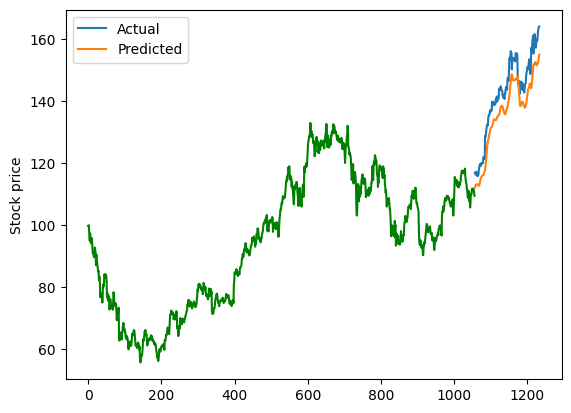

In [11]:
price_close = np.array(data['Close'])

# Scaling data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_price = scaler.fit_transform(price_close.reshape(-1, 1))

train_data = scaled_price[:train_test_split_idx]
test_data  = scaled_price[train_test_split_idx:]

lstm_x_train = []
lstm_y_train = []
lstm_x_test  = []
lstm_y_test  = []

###############################################
#    Hyper-parameter Sliding window - tuning  #
###############################################

# Uncomment the below code to tune the sliding window hyper-parameter
# sliding_window = utility.get_best_sliding_window(train_data, test_data, scaler)
# print("Best sliding window size: ", sliding_window)

for i in range(sliding_window, len(train_data)):
    lstm_x_train.append(train_data[i-sliding_window:i])
    lstm_y_train.append(train_data[i])

for i in range(sliding_window, len(test_data)):
    lstm_x_test.append(test_data[i-sliding_window:i])
    lstm_y_test.append(test_data[i])

lstm_x_train, lstm_y_train, lstm_x_test, lstm_y_test = np.array(lstm_x_train), np.array(lstm_y_train), np.array(lstm_x_test), np.array(lstm_y_test)
lstm_x_train = np.reshape(lstm_x_train, (lstm_x_train.shape[0], lstm_x_train.shape[1], 1))
lstm_x_test = np.reshape(lstm_x_test, (lstm_x_test.shape[0], lstm_x_test.shape[1], 1))

# Build LSTM
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape= (lstm_x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(lstm_x_train, lstm_y_train, batch_size=16, epochs=10)

y_pred = model.predict(lstm_x_test)
y_pred_inv = scaler.inverse_transform(y_pred)

lstm_y_train_inv = scaler.inverse_transform(lstm_y_train)
lstm_y_test_inv  = scaler.inverse_transform(lstm_y_test)

# Calculating Train RMSE
y_pred = model.predict(lstm_x_train)
y_pred_inv = scaler.inverse_transform(y_pred)
mse = mean_squared_error(lstm_y_train_inv, y_pred_inv)
print('Train RMSE: ', np.sqrt(mse))

# Calculating Test RMSE
y_pred = model.predict(lstm_x_test)
y_pred_inv = scaler.inverse_transform(y_pred)
mse = mean_squared_error(lstm_y_test_inv, y_pred_inv)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
lstm_plot_y_train = pd.DataFrame(data=lstm_y_train_inv, columns=['Close'])
lstm_plot_y_test  = pd.DataFrame(data=lstm_y_test_inv, columns=['Close'])
utility.plot_actual_predicted_val(lstm_plot_y_train, lstm_plot_y_test, y_pred_inv)

# <b>Sentiment analysis for Stock price prediction</b>

<b>Sentiment Analysis:</b> Using the stocknet dataset for historical tweet data from twitter. The implementation analyses the tweet sentiment using a pre-trained model from hugging face, specialized in financial news sentiment analysis, and stores the predominant sentiment for each day.

<b>Data Preparation: </b> A dataset with features having Yesterday's ['Open', 'MA_50','MA_100', 'MA_200', 'RSI', 'sentiment'] is used to predict today's 'Close' price is being used.

<b>Model:</b> XGBoostRegression model is used to predict stock prices, refined through fine-tuning with Optuna.

File: 2014-10-14
['$AAPL - Calendrier des soci\\u00e9t\\u00e9s sur 15 jours http:\\/\\/t.co\\/omr7eZoQiC', 'RT @MarketSmith: Great and Timely Post via @jfahmy: 4 Things To Do During Downtrends http:\\/\\/t.co\\/62Pv4YQZum $AAPL $GMCR $NFLX', '$AAPL - Retail Sales Seen Down 0.1%--Data Week Ahead http:\\/\\/t.co\\/BKaQeTYQ0Y', 'Skeptics ask, \\', '$AAPL News: \\', '$S SPRINT will let U lease iPhone 6 or 6 Plus for just $5\\/month net-- promo available till Jan 15. UNLIMITED DATA PLAN $50\\/mo\\n\\n$AAPL', 'RT @DeidreZune: Suspicious stock sales by CEO and COO of $GTAT -- after they knew they could NOT deliver on their contract w\\/ $AAPL http:\\/\\/\\u2026', "Sell $AAPL!!! Make 100% a year using our 'Top 10 Hedge Fund' Artificial Intelligence - http:\\/\\/t.co\\/x7MDlPJXnp $SPY @CNBC", "Samsung's Chip Expansion Antagonistic For Micron? Wall Street, 'The Crowd' At Odds http:\\/\\/t.co\\/5SCpmaRln1 $AAPL $MU $SSNLF", 'What a disaster for investors $AAPL @tim_cook', 'RT @WSJ: One analyst pr

[I 2023-11-19 13:58:51,580] A new study created in memory with name: no-name-1e831282-e7ae-4a8d-bfcd-a2302cf00207
[I 2023-11-19 13:58:51,607] Trial 0 finished with value: 7.751312752775314 and parameters: {'booster': 'gbtree', 'n_estimators': 163, 'subsample': 0.49880560984207234, 'colsample_bytree': 0.27983731642467813, 'min_child_weight': 2.782565782836616, 'lambda': 0.7605307121989587, 'alpha': 0.16911083656253545, 'max_depth': 1, 'eta': 0.003040034742832493, 'gamma': 0.4237861601304585, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.751312752775314.
[I 2023-11-19 13:58:51,655] Trial 1 finished with value: 7.703401548674333 and parameters: {'booster': 'gbtree', 'n_estimators': 94, 'subsample': 0.8342192980103548, 'colsample_bytree': 0.6716606267181524, 'min_child_weight': 5.882899312101351, 'lambda': 0.14217004760152696, 'alpha': 0.3733407600514692, 'max_depth': 7, 'eta': 3.4250380089316126e-05, 'gamma': 2.965595722907858e-05, 'grow_policy': 'depthwise'}. Best is trial 1

Sentiment counts: Counter({'neutral': 12, 'positive': 1, 'negative': 1})
Sentiment: neutral
--------------------
            Date        Open        High         Low       Close   Adj Close    Volume
1253  2017-08-28  160.139999  162.000000  159.929993  161.470001  161.470001  25966000
1254  2017-08-29  160.100006  163.119995  160.000000  162.910004  162.910004  29516900
1255  2017-08-30  163.800003  163.889999  162.610001  163.350006  163.350006  27269600
1256  2017-08-31  163.639999  164.520004  163.479996  164.000000  164.000000  26785100
1257  2017-09-01  164.800003  164.940002  163.630005  164.050003  164.050003  16552800


[I 2023-11-19 13:58:52,511] Trial 2 finished with value: 7.705502882425663 and parameters: {'booster': 'dart', 'n_estimators': 128, 'subsample': 0.8269191046469346, 'colsample_bytree': 0.3553888711908363, 'min_child_weight': 1.8141341434381664, 'lambda': 0.30070005663620336, 'alpha': 0.11398436186354977, 'max_depth': 8, 'eta': 2.3723051688905587e-08, 'gamma': 0.0010239934684337197, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.3318126555538504e-06, 'skip_drop': 0.11789403622841282}. Best is trial 1 with value: 7.703401548674333.
[I 2023-11-19 13:58:52,714] Trial 3 finished with value: 12.633662874525605 and parameters: {'booster': 'dart', 'n_estimators': 64, 'subsample': 0.7568845262695428, 'colsample_bytree': 0.2209216157140511, 'min_child_weight': 4.457030038229796, 'lambda': 0.9442607122388011, 'alpha': 0.9876254749018722, 'max_depth': 5, 'eta': 0.040642718641657936, 'gamma': 1.0256355687768682e-06, 'grow_policy': 'lossguide', 'sam

Best Hyperparameters: {'booster': 'gbtree', 'n_estimators': 89, 'subsample': 0.15414121252228846, 'colsample_bytree': 0.8369226976632516, 'min_child_weight': 1.7526110234172647, 'lambda': 0.2941848745346525, 'alpha': 0.0003425726519810657, 'max_depth': 1, 'eta': 0.13790329613116745, 'gamma': 2.0233067990940414e-05, 'grow_policy': 'lossguide'}
Train RMSE: 2.007527662179979
Test RMSE: 2.9982334535583823


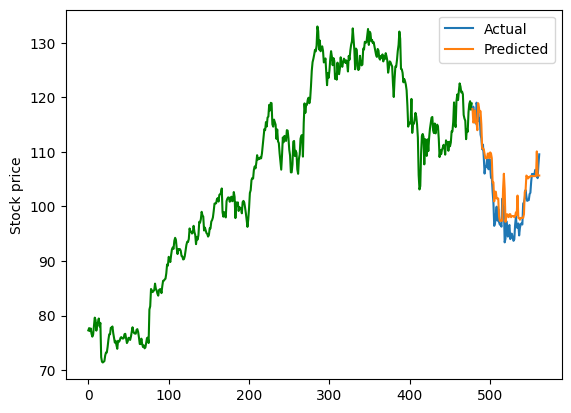

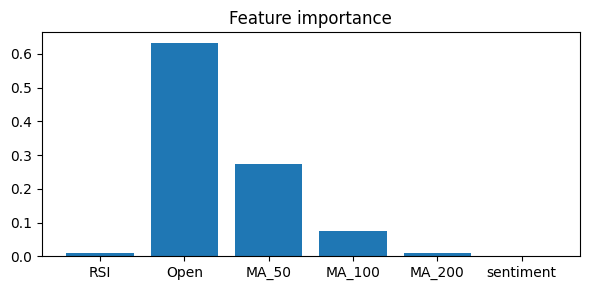

Test RMSE:  2.9982334535583823
Your model is successfully validated.
🔎 Running scan…
2023-11-19 13:59:12,080 pid:15206 MainThread giskard.scanner.logger INFO     Running detectors: ['DataLeakageDetector', 'EthicalBiasDetector', 'TextPerturbationDetector', 'PerformanceBiasDetector', 'StochasticityDetector']
Running detector DataLeakageDetector…
2023-11-19 13:59:12,080 pid:15206 MainThread giskard.scanner.logger INFO     DataLeakageDetector: Running
2023-11-19 13:59:12,095 pid:15206 MainThread giskard.scanner.logger ERROR    Detector DataLeakageDetector failed with error: zero-dimensional arrays cannot be concatenated
DataLeakageDetector: 0 issue detected. (Took 0:00:00.014706)
Running detector EthicalBiasDetector…
2023-11-19 13:59:12,095 pid:15206 MainThread giskard.scanner.logger INFO     EthicalBiasDetector: Running with transformations=['Switch Gender', 'Switch Religion', 'Switch countries from high- to low-income and vice versa'] threshold=None output_sensitivity=None num_samples=No

<iframe id="scan-13855939856" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co

In [12]:
# Utility API for extracting and processing tweets

# Load the sentiment analysis pipeline
sentiment_analysis_pipeline = pipeline(
    "sentiment-analysis",
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
)

tweet_dict = {} # filename: [tweet1, tweet2, ...]

# Extract the first occurrence of text key from a line
# input: line of text from raw tweets in stocknet
# output: text content of the tweet 
def extract_first_text(line):
    match = re.search(tweet_text_pattern, line)
    return match.group(1) if match else None

# Function to extract tweets from a file
# input: filepath
# output: list of tweets
def extract_tweet(file_path):
    extracted_texts = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line_number, line in enumerate(file, start=1):
            extracted_text = extract_first_text(line)
            if extracted_text is not None:
                extracted_texts.append(extracted_text)
    return extracted_texts

# Analyse sentiments of tweets from a given day
# Return sentiment that was most prominent across tweets from that day
def analyze_sentiment(text):
    result = sentiment_analysis_pipeline(text)
    labels = [item['label'] for item in result]

    total_labels = len(labels)
    label_counts = Counter(labels)
    print(f"Sentiment counts: {label_counts}")
    max_label = max(label_counts, key=label_counts.get)

    # if maximum tweets are neutral look for the next best sentiment 
    if max_label == 'neutral' and label_counts[max_label] < 0.7 * total_labels:
        del label_counts[max_label]
        if len(label_counts) > 0:
            max_label = max(label_counts, key=label_counts.get)
    return max_label

# Iterate through all files in the directory
# Prepare a dictionary with filename(date) and list of tweets from that date
for filename in os.listdir(tweet_dir_path):
    file_path = os.path.join(tweet_dir_path, filename)
    if os.path.isfile(file_path):
        extracted_tweets = extract_tweet(file_path)
        if extracted_tweets:
            tweet_dict[filename] = extracted_tweets

# Extract the overall sentiment from all the tweets collected on a given day
df_tweet = pd.DataFrame(columns=["sentiment"])
for filename, extracted_tweets in tweet_dict.items():
    print(f"File: {filename}")
    print(extracted_tweets)
    sentiment = analyze_sentiment(extracted_tweets)
    print(f"Sentiment: {sentiment}")
    df_tweet.loc[filename] = sentiment
    print('-' * 20)

# Tweets are available only from Jan 1, 2014 to March 31, 2016
# Using stock price from the corresponding dates
data = pd.read_csv(tweet_data_path)
train_test_split_idx = int(data.shape[0] * train_test_ratio)
print(data.tail())
df_price = data.loc[(data['Date'] > '2014-01-01') & (data['Date'] < '2016-03-31')]
ta_data  = ta.add_all_ta_features(df_price.copy(), "Open", "High", "Low", "Close", "Volume", fillna=True)

xgb_data = pd.DataFrame(ta_data[['momentum_rsi', 'Open']])
xgb_data.rename(columns = {'momentum_rsi':'RSI'}, inplace = True)

MA = [50, 100, 200]
for avg in MA:
    column_name = f"MA_{avg}"
    xgb_data[column_name] = ta_data['Close'].rolling(avg).mean()
    
xgb_data['sentiment'] = df_tweet['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
xgb_data.fillna(0, inplace=True)

train_test_split_idx = int(xgb_data.shape[0] * train_test_ratio)

X_train = xgb_data[:train_test_split_idx]
X_test  = xgb_data[train_test_split_idx:]

y_train = ta_data['Close'].shift(-1)[:train_test_split_idx]
y_test  = ta_data['Close'].shift(-1)[train_test_split_idx:]

# print(X_train.head())
# Dropping the last row to remove NaN values
X_train = X_train[:-1]
y_train = y_train[:-1]

X_test = X_test[:-1]
y_test = y_test[:-1]

# print(X_train.head())
def objective(trial):
    param = {
        "verbosity": 0,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.9),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1), 
        'objective': 'reg:squarederror',
        'random_state':42
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)

    xgb_optuna_y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, xgb_optuna_y_pred)

    return np.sqrt(test_mse)

study_ma = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=10))
study_ma.optimize(objective, n_trials=100)
best_params = study_ma.best_params

best_xgb_model_with_sentiment = xgb.XGBRegressor(**best_params, random_state=42, objective='reg:squarederror')
best_xgb_model_with_sentiment.fit(X_train, y_train)

print('Best Hyperparameters:', best_params)

# Calculating Train RMSE
y_pred = best_xgb_model_with_sentiment.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print('Train RMSE:', np.sqrt(mse))

# Calculating Test RMSE
y_pred = best_xgb_model_with_sentiment.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Test RMSE:', np.sqrt(mse))

xgb_plot_y_train = pd.DataFrame(data=y_train, columns=['Close'])
xgb_plot_y_test  = pd.DataFrame(data=y_test, columns=['Close'])
utility.plot_actual_predicted_val(xgb_plot_y_train, xgb_plot_y_test, y_pred)

importances = best_xgb_model_with_sentiment.feature_importances_
features = ['RSI', 'Open', 'MA_50','MA_100', 'MA_200','sentiment']
# print(importances)
plt.figure(figsize = (6,3))
plt.bar(features , importances)
plt.title("Feature importance")
plt.tight_layout()
plt.show()

# Data preparation for Giskard
y_test = pd.DataFrame(y_test)
y_test.rename(columns = {'Close':'Target_Close'}, inplace = True)
raw_data      = pd.concat([X_test, y_test], axis=1) 

utility.get_giskard_analysis(X_test, y_test, 'Target_Close', best_xgb_model_with_sentiment, 'XGBoost with Sentiment Analysis for Stock price prediction')

# <b>Experimentation</b>

## <b>Stock price prediction using Technical Indicators</b>

### <b>Indicators being considered</b>

Trend SMA Slow: Moving average of the closing price of the last 26 days

Force Index: It illustrates how strong the actual buying or selling pressure is. High positive values mean there is a strong rising trend, and low values signify a strong downward trend.

Money Flow Index: Uses both price and volume to measure buying and selling pressure. It is positive when the typical price rises (buying pressure) and negative when the typical price declines (selling pressure)

Bollinger Bands: Volatility bands placed above and below a moving average. The bands automatically widen when volatility increases and contract when volatility decreases. 

Moving Average Convergence Divergence (MACD): Subtracts the longer moving average from the shorter one. As a result, the MACD offers the best of both worlds: trend following and momentum. 

Mass Index: Uses the high-low range to identify trend reversals based on range expansions. It identifies range bulges that can foreshadow a reversal of the current trend.

Relative Strength Index (RSI): Compares the magnitude of recent gains and losses over a specified time period to measure speed and change of price movements of a security. \
It is primarily used to attempt to identify overbought or oversold conditions in the trading of an asset.

[I 2023-11-19 14:12:37,901] A new study created in memory with name: no-name-f73a170c-f3df-4260-82d1-2d38f2275fd4
[I 2023-11-19 14:12:37,957] Trial 0 finished with value: 46.1166922770189 and parameters: {'booster': 'gbtree', 'n_estimators': 163, 'subsample': 0.49880560984207234, 'colsample_bytree': 0.27983731642467813, 'min_child_weight': 2.782565782836616, 'lambda': 0.7605307121989587, 'alpha': 0.16911083656253545, 'max_depth': 1, 'eta': 0.003040034742832493, 'gamma': 0.4237861601304585, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 46.1166922770189.
[I 2023-11-19 14:12:38,041] Trial 1 finished with value: 47.76513872894757 and parameters: {'booster': 'gbtree', 'n_estimators': 94, 'subsample': 0.8342192980103548, 'colsample_bytree': 0.6716606267181524, 'min_child_weight': 5.882899312101351, 'lambda': 0.14217004760152696, 'alpha': 0.3733407600514692, 'max_depth': 7, 'eta': 3.4250380089316126e-05, 'gamma': 2.965595722907858e-05, 'grow_policy': 'depthwise'}. Best is trial 0 w

Train RMSE:  3.546358800104707
Test RMSE:  5.9023001189348285


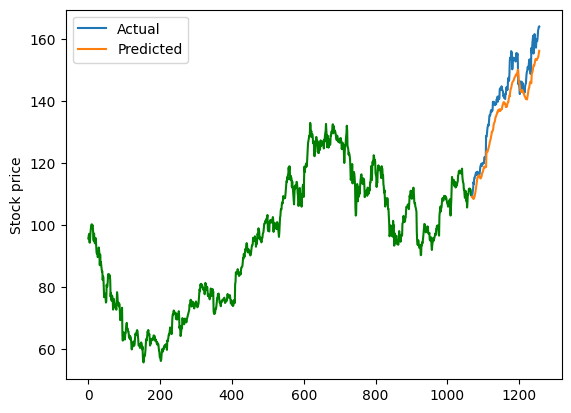

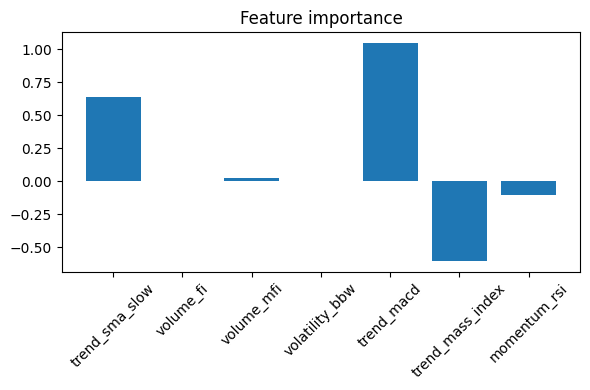

Test RMSE:  5.9023001189348285
Your model is successfully validated.
🔎 Running scan…
2023-11-19 14:13:01,975 pid:15206 MainThread giskard.scanner.logger INFO     Running detectors: ['DataLeakageDetector', 'EthicalBiasDetector', 'TextPerturbationDetector', 'PerformanceBiasDetector', 'StochasticityDetector']
Running detector DataLeakageDetector…
2023-11-19 14:13:01,975 pid:15206 MainThread giskard.scanner.logger INFO     DataLeakageDetector: Running
2023-11-19 14:13:01,989 pid:15206 MainThread giskard.scanner.logger ERROR    Detector DataLeakageDetector failed with error: zero-dimensional arrays cannot be concatenated
DataLeakageDetector: 0 issue detected. (Took 0:00:00.014927)
Running detector EthicalBiasDetector…
2023-11-19 14:13:01,990 pid:15206 MainThread giskard.scanner.logger INFO     EthicalBiasDetector: Running with transformations=['Switch Gender', 'Switch Religion', 'Switch countries from high- to low-income and vice versa'] threshold=None output_sensitivity=None num_samples=No

<iframe id="scan-13859987344" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co

In [16]:
# Create an objective for Optuna Study
def objective(trial):
    param = {
        "verbosity": 0,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.9),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1), 
        'objective': 'reg:squarederror',
        'random_state':42
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = xgb.XGBRegressor(**param)
    model.fit(ta_X_train, ta_y_train)

    xgb_optuna_y_pred = model.predict(ta_X_test)
    test_mse = mean_squared_error(ta_y_test, xgb_optuna_y_pred)

    return np.sqrt(test_mse)

# Create Optuna Study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=10))
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_xgb_model_ta = xgb.XGBRegressor(**best_params, verbosity=0, random_state=42, objective='reg:squarederror')
best_xgb_model_ta.fit(ta_X_train, ta_y_train)

# Calculating Train RMSE
y_pred = best_xgb_model_ta.predict(ta_X_train)
mse = mean_squared_error(ta_y_train, y_pred)
print('Train RMSE: ', np.sqrt(mse))

# Calculating Test RMSE
y_pred = best_xgb_model_ta.predict(ta_X_test)
mse = mean_squared_error(ta_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(ta_plot_y_train, ta_plot_y_test, y_pred)

importances = best_xgb_model_ta.feature_importances_
features = ['trend_sma_slow', 'volume_fi', 'volume_mfi', 'volatility_bbw', 'trend_macd', 'trend_mass_index', 'momentum_rsi']

# print(importances)
plt.figure(figsize = (6,4))
plt.xticks(rotation=45)
plt.bar(features , importances)
plt.title("Feature importance")
plt.tight_layout()
plt.show()

y_test = pd.DataFrame(ta_y_test)
TARGET_COLUMN = 'Close'
MODEL_NAME    = company_name + ' Stock price prediction'  

utility.get_giskard_analysis(ta_X_test, y_test, TARGET_COLUMN, best_xgb_model_ta, 'XGBoost with Technical indicators for stock price prediction')

## <b>Stock price prediction of an unseen company</b>

In [17]:
# Prepare data for another company
company_name           = "CSCO"
filename               = ml_data_path + company_name + ".csv"

train_test_ratio       = 0.15
sliding_window         = 12
tweet_dir_path         = 'data/stocknet-dataset-master/tweet/raw/' + company_name
tweet_text_pattern     = r'"text":"([^"]*)"'

# Read data
data = pd.read_csv(filename)
train_test_split_idx = int(data.shape[0] * train_test_ratio)
print(data.tail())


######################################
##        Data for ARIMA model      ##
######################################
sm_data  = pd.DataFrame(data['Close'])
sm_train = sm_data[:train_test_split_idx]
sm_test  = sm_data[train_test_split_idx:]



######################################
##       Data for Prophet model     ##
######################################
prophet_data = pd.DataFrame(data[['Date', 'Close']])
# Convert date to datetime object
prophet_data['Date'] = pd.to_datetime(prophet_data['Date'], utc=True)
# Prophet expects data with two columns ds and y
prophet_data['ds'] = prophet_data['Date'].dt.date
prophet_data['y']  = prophet_data['Close']
prophet_train = prophet_data[:train_test_split_idx]
prophet_test  = prophet_data[train_test_split_idx:]



######################################
##    Data for Regression models   ##
######################################
reg_data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
reg_X = reg_data
reg_y = data['Close'].shift(-1)  # Shifting 'Close' to predict the next day's value
reg_X = reg_X[:-1] # Drop last entry as it will be NaN
reg_y = reg_y[:-1]
reg_X_train = reg_X[:train_test_split_idx]
reg_y_train = reg_y[:train_test_split_idx]
reg_X_test  = reg_X[train_test_split_idx:]
reg_y_test  = reg_y[train_test_split_idx:]
reg_plot_y_train = pd.DataFrame(data=reg_y_train, columns=['Close'])
reg_plot_y_test  = pd.DataFrame(data=reg_y_test, columns=['Close'])



######################################################
##    Data for models using technical indicators    ##
######################################################

df_technical_indicators = ta.add_all_ta_features(data, "Open", "High", "Low", "Close", "Volume", fillna=True)
ta_data = df_technical_indicators[['trend_sma_slow', 'volume_fi', 'volume_mfi', 'volatility_bbw', 'trend_macd', 'trend_mass_index', 'momentum_rsi']]
ta_X = ta_data
ta_y = data['Close'].shift(-1)  # Shifting 'Close' to predict the next day's value
ta_X = ta_X[:-1] # Drop last entry as it will be NaN
ta_y = ta_y[:-1]
ta_X_train = ta_X[:train_test_split_idx]
ta_y_train = ta_y[:train_test_split_idx]
ta_X_test  = ta_X[train_test_split_idx:]
ta_y_test  = ta_y[train_test_split_idx:]
ta_plot_y_train = pd.DataFrame(data=ta_y_train, columns=['Close'])
ta_plot_y_test  = pd.DataFrame(data=ta_y_test, columns=['Close'])

            Date       Open       High        Low      Close  Adj Close    Volume
1253  2017-08-28  31.600000  31.660000  31.410000  31.540001  31.540001  12958900
1254  2017-08-29  31.260000  31.629999  31.190001  31.480000  31.480000  16362700
1255  2017-08-30  31.469999  32.200001  31.420000  31.990000  31.990000  22988700
1256  2017-08-31  32.099998  32.340000  31.990000  32.209999  32.209999  27800200
1257  2017-09-01  32.220001  32.349998  32.029999  32.299999  32.299999  14679700


Test RMSE:  0.4553501430037385


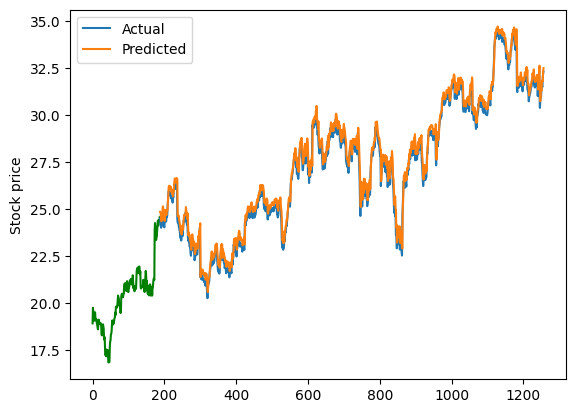

In [18]:
# Linear Regression for Cisco stock price
y_pred_lr = lr_model.predict(reg_X_test)

# Calculate RMSE
mse = mean_squared_error(reg_y_test, y_pred_lr)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred_lr)

Test RMSE:  0.3499681651950295


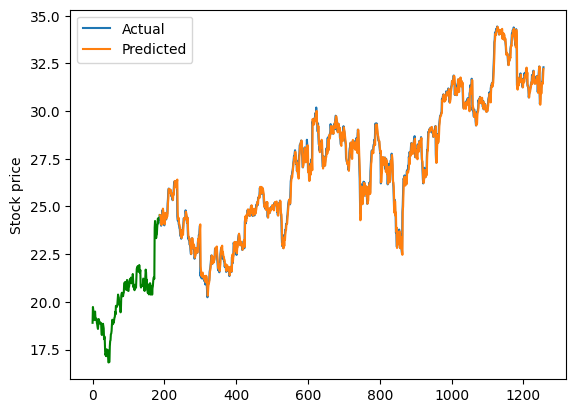

In [19]:
# Linear Regression prediction by training on small portion of Cisco stock data
lr_model.fit(reg_X_train, reg_y_train)

y_pred_lr = lr_model.predict(reg_X_test)

# Calculate RMSE
mse = mean_squared_error(reg_y_test, y_pred_lr)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred_lr)

Test RMSE:  30.01053079426449


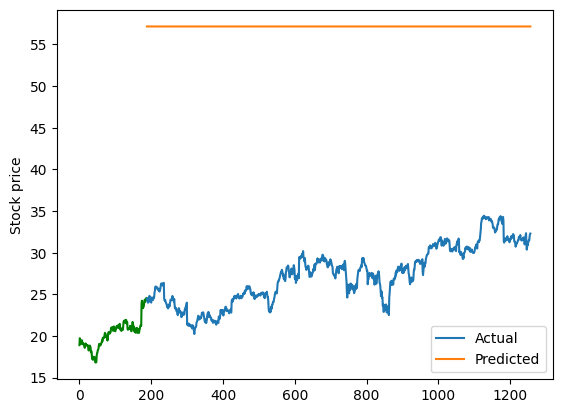

In [20]:
# Decision Tree Regressor for Cisco stock price
y_pred = best_dt_regressor.predict(reg_X_test)

# Calculating RMSE
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

Test RMSE:  4.3990084755613665


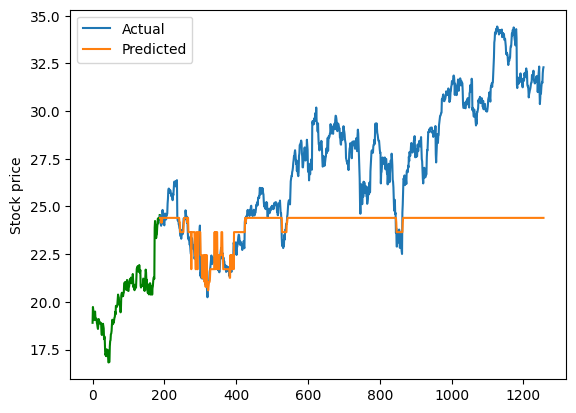

In [21]:
# Decision Tree Regressor prediction by training on small portion of Cisco stock data
best_dt_regressor.fit(reg_X_train, reg_y_train)
# Make predictions on the test set
y_pred = best_dt_regressor.predict(reg_X_test)

# Calculating RMSE
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

Test RMSE:  30.24618611407164


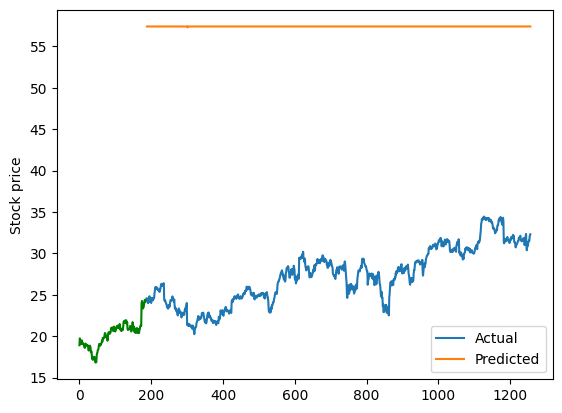

In [22]:
# Random Forest Regressor for Cisco stock price
y_pred = best_rf_regressor.predict(reg_X_test)

# Calculating RMSE
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

Test RMSE:  4.3990084755613665


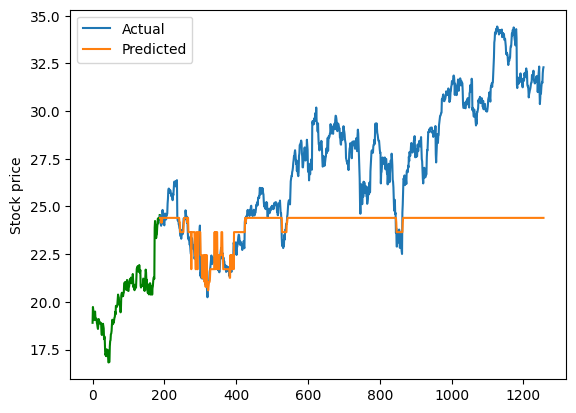

In [23]:
# Random Forest Regressor prediction by training on small portion of Cisco stock data
best_rf_regressor.fit(reg_X_train, reg_y_train)
# Make predictions on the test set
y_pred = best_dt_regressor.predict(reg_X_test)

# Calculating RMSE
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

Test RMSE:  3.8431980188302286


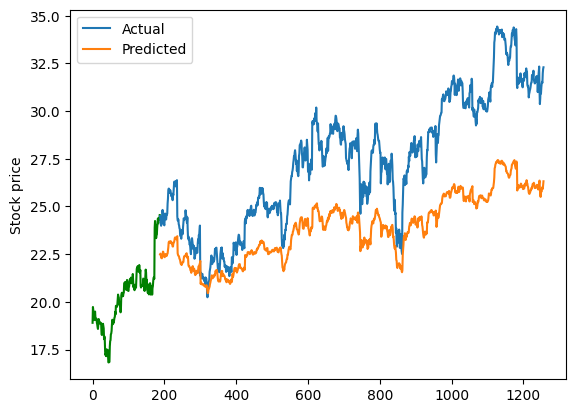

In [26]:
# XGBoost Regressor for Cisco stock price

y_pred = best_xgb_model.predict(reg_X_test)

# Calculating RMSE
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

Test RMSE:  4.043277508193847


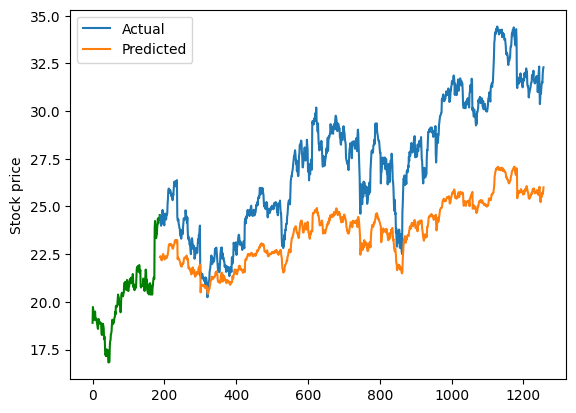

In [27]:
# XGBoost Regressor prediction by training on small portion of Cisco stock data
best_xgb_model.fit(reg_X_train, reg_y_train)

y_pred = best_xgb_model.predict(reg_X_test)
#y_pred = best_dt_regressor.predict(reg_X_test)

# Calculating RMSE
mse = mean_squared_error(reg_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)

Test RMSE:  5.645595770848877


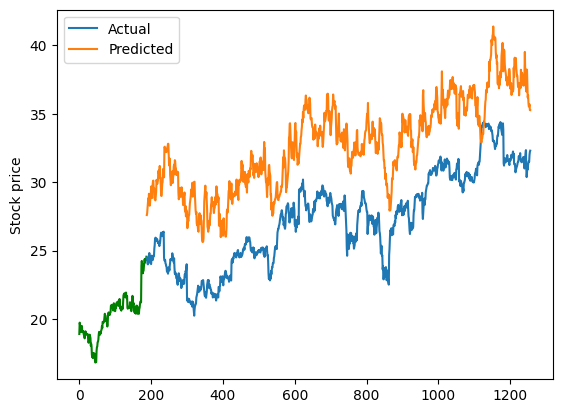

In [28]:
# XGBoost Regressor (trained on technical indicators) for Cisco stock price
y_pred = best_xgb_model_ta.predict(ta_X_test)

# Calculating RMSE
mse = mean_squared_error(ta_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(ta_plot_y_train, ta_plot_y_test, y_pred)

Test RMSE:  6.574475306301083


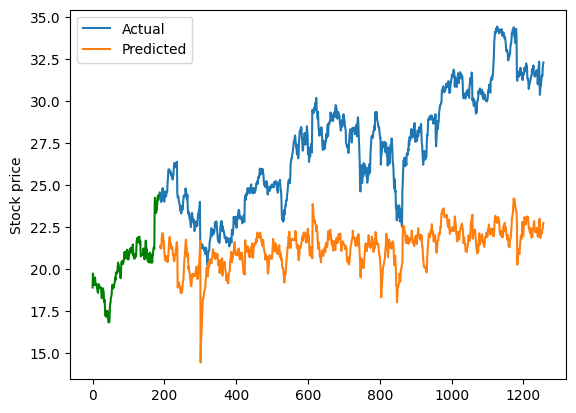

In [29]:
# XGBoost Regressor (trained on technical indicators) prediction by training on small portion of Cisco stock data
best_xgb_model.fit(ta_X_train, ta_y_train)

y_pred = best_xgb_model.predict(ta_X_test)
#y_pred = best_dt_regressor.predict(reg_X_test)

# Calculating RMSE
mse = mean_squared_error(ta_y_test, y_pred)
print('Test RMSE: ', np.sqrt(mse))

# Plot the predictions
utility.plot_actual_predicted_val(reg_plot_y_train, reg_plot_y_test, y_pred)